# Loading necessary libraries

In [2]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
from IPython.display import clear_output

2025-06-20 18:15:59.157108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750443359.633934      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750443359.788238      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading and preprocessing the training and validation datasets

In [2]:
# Paths
img_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
partition_file = '/kaggle/input/celeba-dataset/list_eval_partition.csv'

# Load partition information
partition_df = pd.read_csv(partition_file)

# Mapping partitions
partition_df.columns = ['image_id', 'partition']

# Create lists of file paths
train_files = partition_df[(partition_df['partition'] == 0)]['image_id'].tolist()
val_files = partition_df[(partition_df['partition'] == 2)]['image_id'].tolist()

# Add directory prefix to image IDs
train_files = [os.path.join(img_dir, img_id) for img_id in train_files]
val_files = [os.path.join(img_dir, img_id) for img_id in val_files]

# Function to load and preprocess images before preparing the dataset
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path) # Load the image file
    img = tf.image.decode_jpeg(img, channels=3) # Decode the image into a 3-channel (RGB) format
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float32 in [0, 1]
    img = tf.image.resize(img, [64, 64])  # Resize to the desired size
    return img

batch_size = 32

# Creating TensorFlow datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices(train_files).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1750438001.403998      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750438001.404968      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Define the sampling layer and β-VAE

In [3]:
latent_dim = 32

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
    def compute_output_shape(self, input_shape):
        return input_shape[0]


# Seed to ensure reproducibility 
np.random.seed(42)
tf.random.set_seed(42)

beta = 1.5  # Hyperparameter for KL-divergence weight

# Beta-VAE architecture
class BetaVAE(Model):
    def __init__(self, encoder, decoder, beta):
        super(BetaVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.sampling = Sampling() 

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        # Forward pass
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            ))
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + self.beta * kl_loss

        # Apply gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }

    def test_step(self, data):
        # Forward pass
        z_mean, z_log_var = self.encoder(data)
        z = self.sampling([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        
        # Compute losses
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
        ))
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + self.beta * kl_loss
        return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss
    }

# Loading a previously trained and saved autoencoder (to save time and skip the training process)

In [4]:
# Loading the encoder and decoder
encoder = tf.keras.models.load_model('/kaggle/input/betavae1-5/encoder_1_arch.h5')
decoder = tf.keras.models.load_model('/kaggle/input/betavae1-5/decoder_1_arch.h5')
vae = BetaVAE(encoder, decoder, beta)
vae(tf.keras.Input(shape=(64, 64, 3)))

vae.get_layer('encoder').load_weights('/kaggle/input/betavae1-5/encoder_1.weights.h5') 
vae.get_layer('decoder').load_weights('/kaggle/input/betavae1-5/decoder_1.weights.h5')
vae.compile(optimizer=tf.keras.optimizers.Adam())

encoder.summary()
decoder.summary()
vae.summary()

# Storing the weights of the first layer of the decoder for usage after rotation of latent space
W, bias = decoder.layers[1].get_weights()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │          1,568 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         32,832 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │        131,200 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      2,097,408 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          8,224 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │          8,224 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,279,456 (8.70 MB)

 Trainable params: 2,279,456 (8.70 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8192)                │         270,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,411 (2.66 MB)

 Trainable params: 697,411 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Model: "beta_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ [(None, 32), (None, 32)]    │       2,279,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 64, 64, 3)           │         697,411 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling (Sampling)                  │ (None, 32)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,976,867 (11.36 MB)

 Trainable params: 2,976,867 (11.36 MB)

 Non-trainable params: 0 (0.00 B)

# Define the encoder and decoder structure (Not required if a previously trained and saved autoencoder is loaded before)

In [20]:
# Encoder
def build_encoder():
    inputs = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(32, 4, strides=2, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, 4, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 4, strides=2, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return Model(inputs, [z_mean, z_log_var], name='encoder')


# Decoder
def build_decoder():
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 128, activation='relu')(inputs)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 4, strides=2, activation='relu', padding='same')(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return Model(inputs, outputs, name='decoder')

# Instantiate the model
encoder = build_encoder()
decoder = build_decoder()
vae = BetaVAE(encoder, decoder, beta)
vae(tf.keras.Input(shape=(64, 64, 3)))
vae.compile(optimizer=tf.keras.optimizers.Adam())

encoder.summary()
decoder.summary()
vae.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 32)     │          1,568 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 64)     │         32,832 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 8, 8, 128)      │        131,200 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 8192)           │              0 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │      2,097,408 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          8,224 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │          8,224 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,279,456 (8.70 MB)

 Trainable params: 2,279,456 (8.70 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8192)                │         270,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 16, 16, 128)         │         262,272 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 32, 32, 64)          │         131,136 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 64, 64, 32)          │          32,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 64, 64, 3)           │             867 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,411 (2.66 MB)

 Trainable params: 697,411 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Model: "beta_vae_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ [(None, 32), (None, 32)]    │       2,279,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 64, 64, 3)           │         697,411 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling_11 (Sampling)               │ (None, 32)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,976,867 (11.36 MB)

 Trainable params: 2,976,867 (11.36 MB)

 Non-trainable params: 0 (0.00 B)

# Training and saving the autoencoder (Not required if a previously trained and saved autoencoder is loaded before)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
epochs = 50
history = vae.fit(train_dataset, validation_data = val_dataset, epochs=epochs, callbacks = [early_stopping])

# Save the model
vae.get_layer('encoder').save_weights('encoder.weights.h5')
vae.get_layer('decoder').save_weights('decoder.weights.h5')
vae.get_layer('encoder').save('encoder_arch.h5') 
vae.get_layer('decoder').save('decoder_arch.h5')

Epoch 1/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - kl_loss: 31.0081 - loss: 2222.1194 - reconstruction_loss: 2175.6072 - val_kl_loss: 34.2574 - val_loss: 2207.8616 - val_reconstruction_loss: 2156.4756
Epoch 2/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - kl_loss: 34.0563 - loss: 2181.0110 - reconstruction_loss: 2129.9263 - val_kl_loss: 32.9383 - val_loss: 2203.4211 - val_reconstruction_loss: 2154.0137
Epoch 3/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - kl_loss: 34.8701 - loss: 2175.3296 - reconstruction_loss: 2123.0247 - val_kl_loss: 32.9772 - val_loss: 2199.1074 - val_reconstruction_loss: 2149.6416
Epoch 4/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 85s 17ms/step - kl_loss: 35.3577 - loss: 2172.1592 - reconstruction_loss: 2119.1228 - val_kl_loss: 34.0036 - val_loss: 2194.8452 - val_reconstruction_loss: 2143.8398
Epoch 5/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 85s 17ms/step - kl_loss: 35.4910 - loss: 2170.4993 - reconstruction_loss: 2117.2627 - val_kl_loss: 33.8938 - val_loss: 2194.94

# Evaluate and visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


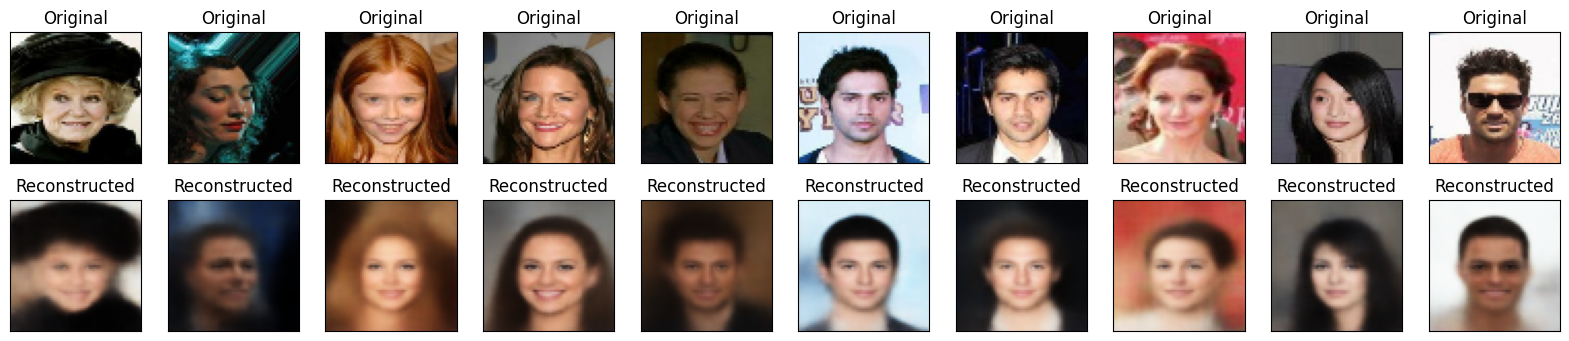

In [50]:
all_original_images = []
all_reconstructed_images = []

for images in val_dataset.take(10):
    # Generate reconstructions
    reconstructed_images = vae.predict(images)
    
    # Collect images and their reconstructions
    all_original_images.extend(images.numpy())
    all_reconstructed_images.extend(reconstructed_images)


# Function to display the original and reconstructed images  
def show_reconstructed_images(original_images, reconstructed_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(min(n, len(original_images))):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.savefig('autoencoder_ip_op.png')
    plt.show()

show_reconstructed_images(all_original_images[:10], all_reconstructed_images[:10])

# Loading attribute data

In [3]:
attributes_file = '/kaggle/input/celeba-dataset/list_attr_celeba.csv'

df_attributes = pd.read_csv(attributes_file)
df = pd.merge(df_attributes, partition_df, left_on='image_id', right_on='image_id')

# Extracting the latent space representation

In [6]:
def sample_latent_space(encoder, dataset, seed=None):

    all_latent_vectors = []
    
    if seed is not None:
        np.random.seed(seed)
        
    for batch in dataset:
        means, log_vars = encoder(batch)
        latent_vectors = Sampling()([means, log_vars])
        all_latent_vectors.append(latent_vectors)
    
    all_latent_vectors = tf.concat(all_latent_vectors, axis=0).numpy()
    return all_latent_vectors


latent_train = sample_latent_space(encoder,train_dataset,42)  # Extract latent space for train set
latent_val = sample_latent_space(encoder, val_dataset, 42)  # Extract latent space for test set

I0000 00:00:1750427386.824461      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


# Applying factor rotation to the latent space representation

In [7]:
selected_attributes = ['Bald', 'Black_Hair', 'Pale_Skin', 'Smiling', 'Eyeglasses']  # Can be any number of attributes
Z_train, Z_val = latent_train, latent_val
# Containers for coefficient vectors
beta_list = []
y_train_attr_list, y_val_attr_list = [],[]

# Loop over each selected attribute name
for attr in selected_attributes:
    # Extract training and validation labels
    y_train_attr = ((df[(df['partition'] == 0)][attr][:162752] + 1)/2).astype(int)
    y_val_attr = ((df[(df['partition'] == 2)][attr][:19936] + 1)/2).astype(int)

    # Train logistic regression
    logistic_model = LogisticRegression()
    logistic_model.fit(latent_train, y_train_attr)

    # Normalize and store the coefficient vector
    beta = logistic_model.coef_.flatten()
    beta /= np.linalg.norm(beta)
    beta_list.append(beta)
    y_train_attr_list.append(y_train_attr)
    y_val_attr_list.append(y_val_attr)

# Construct the matrix B
I_n = np.eye(latent_train.shape[1])
k = len(beta_list)  # number of selected attributes
B = np.column_stack(beta_list + [I_n[:, i] for i in range(k, I_n.shape[1])])  # Fill remaining dimensions

# Perform QR decomposition
Q, _ = np.linalg.qr(B)
R = Q  # The rotation matrix

#Oblique rotation of the latent space based on chosen attributes
R_prime = np.column_stack(beta_list + [Q[:, i] for i in range(k, Q.shape[1])])

# Apply the rotation
Z_train_orth_rotated = Z_train @ R
Z_val_orth_rotated = Z_val @ R

Z_train_obl_rotated = Z_train @ R_prime
Z_val_obl_rotated = Z_val @ R_prime

# Disentanglement metrics

In [8]:
def predictability_matrix(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: (k, n) matrix of ROC AUC scores
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    scores = np.zeros((k, n))
    for i in range(k):
        attr = attrs[:, i]
        for j in range(n):
            clf = LogisticRegression(max_iter=200)
            clf.fit(Z[:, j:j+1], attr)
            prob = clf.predict_proba(Z[:, j:j+1])[:, 1]
            scores[i, j] = roc_auc_score(attr, prob)
    return scores


def compute_sap(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: average SAP score
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    sap_values = []
    for i in range(k):
        attr = attrs[:, i]
        aucs = []
        for j in range(n):
            clf = LogisticRegression(max_iter=200)
            clf.fit(Z[:, j:j+1], attr)
            prob = clf.predict_proba(Z[:, j:j+1])[:, 1]
            auc = roc_auc_score(attr, prob)
            aucs.append(auc)
        aucs = np.sort(aucs)[::-1]
        sap_values.append(aucs[0] - aucs[1])
    return np.mean(sap_values)

def compute_mutual_info_matrix(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: (k, n) matrix of MI scores
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    mi_scores = np.zeros((k, n))
    for i in range(k):
        mi = mutual_info_classif(Z, attrs[:, i], discrete_features=False)
        mi_scores[i] = mi
    return mi_scores


def compute_modularity(mi_matrix):
    """
    Compute the modularity score for a latent code given the mutual information matrix.

    Parameters:
    -----------
    mi_matrix : np.ndarray of shape (k, n)
        Mutual information matrix between each attribute (k) and each latent dimension (n).
        mi_matrix[i, j] = mutual information between attribute i and latent dimension j.

    Returns:
    --------
    modularity : float
        The average modularity score over all latent dimensions, in [0, 1].
    """

    k, n = mi_matrix.shape
    modularity_scores = []

    for j in range(n):
        mi_vec = mi_matrix[:,j]
        theta_j = np.max(mi_vec)
        if theta_j == 0:
            # If no mutual info, modularity is undefined; consider it zero modularity
            modularity_scores.append(0.0)
            continue

        # Construct template vector: theta_j at the max factor index, 0 elsewhere
        template = np.zeros(k)
        max_idx = np.argmax(mi_vec)
        template[max_idx] = theta_j

        # Compute deviation δ_j
        numerator = np.sum((mi_vec - template) ** 2)
        denominator = (theta_j ** 2) * (k - 1)
        delta_j = numerator / denominator if denominator > 0 else 0

        # Modularity for dimension j
        modularity_j = 1 - delta_j
        modularity_scores.append(modularity_j)

    # Average modularity over all latent dimensions
    return np.mean(modularity_scores)

# Evaluate disentanglement metrics

In [12]:
k = len(selected_attributes)
attrs = np.array(y_train_attr_list).T

# Before and after rotation
print("Predictability Matrix")
scores_orig = predictability_matrix(Z_train[:,:k], attrs)
print("Before rotation")
print(scores_orig)
scores_orth_rot = predictability_matrix(Z_train_orth_rotated[:,:k], attrs)
print("After orthogonal rotation")
print(scores_orth_rot)
scores_obl_rot = predictability_matrix(Z_train_obl_rotated[:,:k], attrs)
print("After oblique rotation")
print(scores_obl_rot)
print("\n")

print("Mutual info matrix")
mig_orig = compute_mutual_info_matrix(Z_train[:,:k], attrs)
print("Before rotation")
print(mig_orig)
mig_orth_rot = compute_mutual_info_matrix(Z_train_orth_rotated[:,:k], attrs)
print("After orthogonal rotation")
print(mig_orth_rot)
mig_obl_rot = compute_mutual_info_matrix(Z_train_obl_rotated[:,:k], attrs)
print("After oblique rotation")
print(mig_obl_rot)

print("\n")
mod_orig = compute_modularity(mig_orig)
print(f"Modularity before rotation: {mod_orig}")
mod_orth_rot = compute_modularity(mig_orth_rot)
print(f"Modularity after orthogonal rotation:  {mod_orth_rot}")
mod_obl_rot = compute_modularity(mig_obl_rot)
print(f"Modularity after oblique rotation:  {mod_obl_rot}")
print("\n")

print("SAP score")
sap_orig = compute_sap(Z_train[:,:k], attrs)
print("Before rotation")
print(sap_orig)
sap_orth_rot = compute_sap(Z_train_orth_rotated[:,:k], attrs)
print("After orthogonal rotation")
print(sap_orth_rot)
sap_obl_rot = compute_sap(Z_train_obl_rotated[:,:k], attrs)
print("After oblique rotation")
print(sap_obl_rot)
print("\n")

Predictability Matrix
Before rotation
[[0.50280861 0.49988198 0.50926412 0.503677   0.61719114]
 [0.5022038  0.50141002 0.50142571 0.55205831 0.54729348]
 [0.50780635 0.50228377 0.50107363 0.64988629 0.63242532]
 [0.50021282 0.50214356 0.50058683 0.60188519 0.50297739]
 [0.50805168 0.50287926 0.50113252 0.58886711 0.6142353 ]]
After orthogonal rotation
[[0.88696036 0.53926293 0.50758883 0.5130398  0.56273749]
 [0.61403507 0.78133407 0.50994326 0.49969666 0.49889587]
 [0.58378179 0.64149811 0.87395179 0.50480123 0.52090996]
 [0.5291316  0.5225491  0.56236048 0.77710564 0.50306773]
 [0.72161752 0.54597882 0.59707651 0.6156584  0.72897844]]
After oblique rotation
[[0.88696036 0.71490908 0.57964522 0.54367447 0.77979404]
 [0.61403507 0.80914485 0.56880936 0.51130852 0.5211606 ]
 [0.58378179 0.59113339 0.89466034 0.58917284 0.69015003]
 [0.5291316  0.50904228 0.54352872 0.78876894 0.6035204 ]
 [0.72161752 0.55074887 0.65339556 0.61437423 0.82172196]]


Mutual info matrix
Before rotation
[[0

# Latent space traversal (Orthogonal rotation)

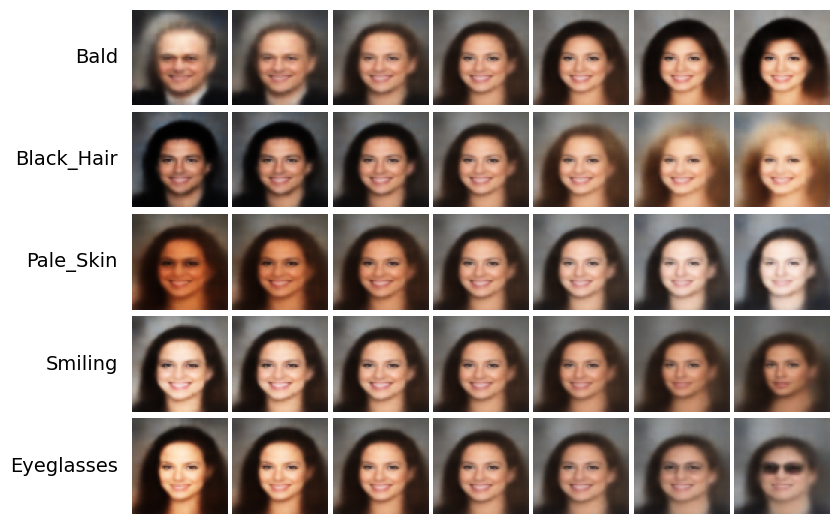

In [54]:
# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
W_adjusted = np.dot(R.T, W)
decoder.layers[1].set_weights([W_adjusted, bias])

# Latent traversal setup
traversal_range = 3.5
steps = 7
linspace = np.linspace(-traversal_range, traversal_range, steps)

# Create subplots
fig, axes = plt.subplots(5, steps, figsize=(steps * 1.2, 6))

fig.subplots_adjust(
    left=0.15,   # reserve space for y-axis labels
    right=0.98,
    top=0.9,
    bottom=0.05,
    wspace=0.05,  # thin vertical strips
    hspace=0.01   # thin horizontal strips
)

for dim in range(5):
    for i, val in enumerate(linspace):
        z = Z_val_orth_rotated[3, :].copy()
        z[dim] += val

        # Decode
        z_tensor = np.expand_dims(z, axis=0)
        decoded_image = decoder.predict(z_tensor, verbose=0)[0]
        decoded_image = np.clip(decoded_image, 0, 1)

        # Plot
        ax = axes[dim, i]
        ax.imshow(decoded_image)
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(
                selected_attributes[dim].replace('_', '\n'),
                fontsize=9,
                rotation=0,
                labelpad=15,
                va='center'
            )
for row in range(5):
    ax = axes[row, 0]  # First image in the row
    ax.text(
        -0.15, 0.5,                                
        selected_attributes[row], 
        va='center', ha='right', 
        fontsize=14, transform=ax.transAxes
    )

# Title
plt.savefig('beta_vae_latent_space_traversal_celeba_orth.jpg')
plt.show()

# Latent space traversal (Oblique rotation)

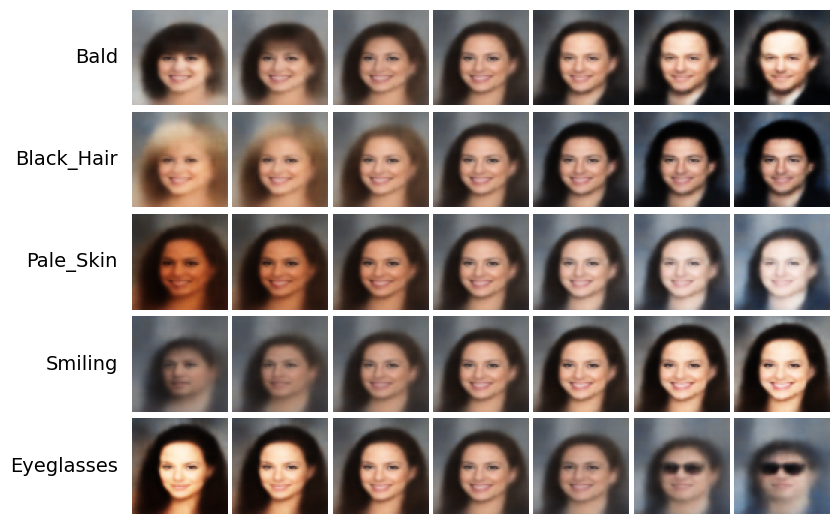

In [11]:
# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
R_prime_inv = np.linalg.inv(R_prime)
W_adjusted = np.dot(R_prime_inv, W)
decoder.layers[1].set_weights([W_adjusted, bias])

# Latent traversal setup
traversal_range = 3.5
steps = 7
linspace = np.linspace(-traversal_range, traversal_range, steps)

# Create subplots
fig, axes = plt.subplots(5, steps, figsize=(steps * 1.2, 6))

fig.subplots_adjust(
    left=0.15,   # reserve space for y-axis labels
    right=0.98,
    top=0.9,
    bottom=0.05,
    wspace=0.05,  # thin vertical strips
    hspace=0.01   # thin horizontal strips
)

for dim in range(5):
    for i, val in enumerate(linspace):
        z = Z_val_obl_rotated[3, :].copy()
        z[dim] += val

        # Decode
        z_tensor = np.expand_dims(z, axis=0)
        decoded_image = decoder.predict(z_tensor, verbose=0)[0]
        decoded_image = np.clip(decoded_image, 0, 1)

        # Plot
        ax = axes[dim, i]
        ax.imshow(decoded_image)
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(
                selected_attributes[dim].replace('_', '\n'),
                fontsize=9,
                rotation=0,
                labelpad=15,
                va='center'
            )
for row in range(5):
    ax = axes[row, 0]  # First image in the row
    ax.text(
        -0.15, 0.5,                               
        selected_attributes[row], 
        va='center', ha='right', 
        fontsize=14, transform=ax.transAxes
    )

# Title
plt.savefig('beta_vae_latent_space_traversal_celeba_obl.jpg')
plt.show()

# Correlation plot between latent space and selected attributes before and after rotation

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


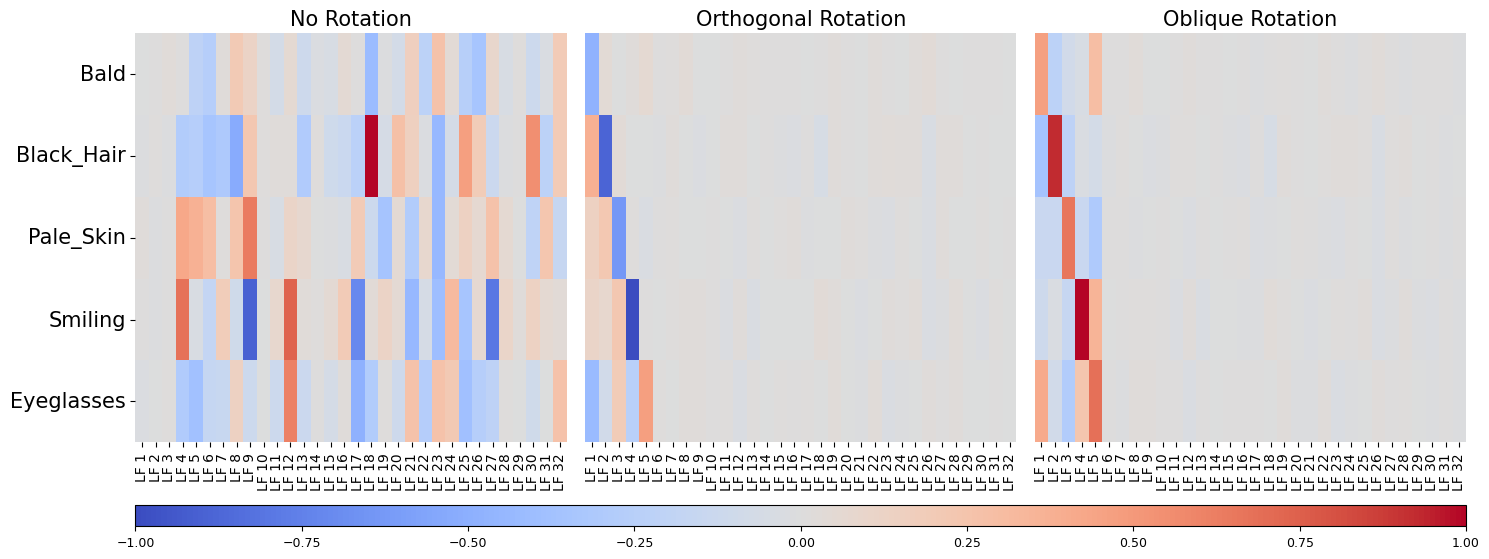

In [12]:
def compute_correlation_matrix(y_attr_list, Z):
    num_attrs = len(y_attr_list)
    latent_dim = Z.shape[1]
    corr_matrix = np.zeros((num_attrs, latent_dim))
    for i, y in enumerate(y_attr_list):
        for j in range(latent_dim):
            corr, _ = pointbiserialr(y, Z[:, j])
            corr_matrix[i, j] = corr
    return corr_matrix

# Compute correlation matrices
corr_unrotated = compute_correlation_matrix(y_train_attr_list, Z_train)
corr_orth = compute_correlation_matrix(y_train_attr_list, Z_train_orth_rotated)
corr_obl = compute_correlation_matrix(y_train_attr_list, Z_train_obl_rotated)

fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(2, 3, height_ratios=[0.95, 0.05]) 

# Heatmap axes
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

heatmap_data = [
    ("No Rotation", corr_unrotated),
    ("Orthogonal Rotation", corr_orth),
    ("Oblique Rotation", corr_obl)
]

ytick_labels = [f'{selected_attributes[i]}' for i in range(len(y_train_attr_list))]

for ax, (title, corr_matrix) in zip(axes, heatmap_data):
    sns.heatmap(
        corr_matrix, cmap='coolwarm', center=0, ax=ax,
        xticklabels=[f'LF {i+1}' for i in range(corr_matrix.shape[1])],
        yticklabels=(ax == axes[0]),  # Only show yticklabels for the first plot
        cbar=False
    )
    ax.set_title(title, fontsize=15)  # <-- customize here
    #ax.set_xlabel('Latent Factors', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    if ax == axes[0]:
        ax.set_yticks(np.arange(len(ytick_labels)) + 0.5)
        ax.set_yticklabels(ytick_labels, rotation=0, fontsize=15)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

# Legend
cbar_ax = fig.add_subplot(gs[1, :])
norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('correlation_heatmap_beta_VAE.jpg')
plt.show()

# Generating reconstructed images from latent space without rotation for training DNN classifers

In [ ]:
# Reverting the weight of the decoder without rotation
decoder.layers[1].set_weights([W, bias])

batch_size = 32
reconstructed_images_train = []

# Generating in batches
for batch in train_dataset:
    batch_reconstructed = vae.predict(batch)
    reconstructed_images_train.append(batch_reconstructed)
    clear_output(wait=True)
     
# Combine all batches into one array
reconstructed_images_train = np.concatenate(reconstructed_images_train, axis=0)

# validation set
reconstructed_images_val = vae.predict(val_dataset)

np.save('reconstructed_images_train.npy', reconstructed_images_train)
np.save('reconstructed_images_val.npy', reconstructed_images_val)

del reconstructed_images_train, reconstructed_images_val
import gc
gc.collect()

# Creating tensorFlow datasets from numpy arrays using generators for efficient data loading

In [8]:
reconstructed_images_train = np.load('/kaggle/working/reconstructed_images_train.npy', mmap_mode='r')
reconstructed_images_val = np.load('/kaggle/working/reconstructed_images_val.npy', mmap_mode='r')

batch_size = 32

# Create a generator function that yields data in batches
def data_generator_train():
    for i in range(0, len(reconstructed_images_train), batch_size):
        yield reconstructed_images_train[i:i+batch_size]

# Convert the generator to a tf.data.Dataset
reconstructed_images_train_dataset = tf.data.Dataset.from_generator(
    data_generator_train, 
    output_signature=tf.TensorSpec(shape=(None, 64,64,3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)


def data_generator_val():
    for i in range(0, len(reconstructed_images_val), batch_size):
        yield reconstructed_images_val[i:i+batch_size]

reconstructed_images_val_dataset = tf.data.Dataset.from_generator(
    data_generator_val, 
    output_signature=tf.TensorSpec(shape=(None, 64,64,3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)

# Combining reconstructed images with attribute labels (This block needs to be changed and executed before training a DNN classifier for a particular attribute)

In [14]:
# Uncomment the code for a particular attribute and comment out the rest

reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[0]).batch(32))) 
reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[0]).batch(32)))

#reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[1]).batch(32))) 
#reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[1]).batch(32)))
#reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[2]).batch(32))) 
#reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[2]).batch(32)))
#reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[3]).batch(32))) 
#reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[3]).batch(32)))
#reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[4]).batch(32))) 
#reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[4]).batch(32)))

reconstructed_dataset_with_labels_train = reconstructed_dataset_with_labels_train.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
reconstructed_dataset_with_labels_val = reconstructed_dataset_with_labels_val.prefetch(tf.data.AUTOTUNE)

# DNN classifier to predict presence of attribute in reconstructed images

In [15]:
def build_probability_model(input_shape=(64,64,3)):
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),  # 16 filters
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Training the DNN classifer (Train for each attribute separately)

In [16]:
# Use this block to train Classifier 1, 2 and 3 for bias mitigation and fairness analysis

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model = build_probability_model()
model.fit(reconstructed_dataset_with_labels_train, epochs=30, validation_data=reconstructed_dataset_with_labels_val, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   5074/Unknown 41s 7ms/step - accuracy: 0.9774 - loss: 0.0884

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5086/5086 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.9774 - loss: 0.0884 - val_accuracy: 0.9788 - val_loss: 0.0740
Epoch 2/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9778 - loss: 0.0720 - val_accuracy: 0.9788 - val_loss: 0.0694
Epoch 3/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9772 - loss: 0.0713 - val_accuracy: 0.9788 - val_loss: 0.0673
Epoch 4/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9775 - loss: 0.0692 - val_accuracy: 0.9788 - val_loss: 0.0655
Epoch 5/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9773 - loss: 0.0696 - val_accuracy: 0.9788 - val_loss: 0.0672
Epoch 6/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9780 - loss: 0.0674 - val_accuracy: 0.9788 - val_loss: 0.0658
Epoch 7/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9776 - loss: 0.0670 - val_accuracy: 0.9788 - val_loss: 0.0659
Epoch 8/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9776 - loss: 0.0660 - val

# Saving the DNN classifier

In [49]:
model.save('model.keras') # Provide a meaningful name before saving

# Loading saved DNN classifiers

In [23]:
model_paths = [
    '/kaggle/input/attribute-predict-models/bald_attribute_predict_model_no_rot_epoch30_VAE.keras',
    '/kaggle/input/attribute-predict-models/black_hair_attribute_predict_model_no_rot_epoch30_VAE.keras',
    '/kaggle/input/attribute-predict-models/pale_skin_attribute_predict_model_no_rot_epoch30_VAE.keras',
    '/kaggle/input/attribute-predict-models/smiling_attribute_predict_model_no_rot_epoch30_VAE.keras',
    '/kaggle/input/attribute-predict-models/eyeglasses_attribute_predict_model_no_rot_epoch30_VAE.keras'
]
models = [tf.keras.models.load_model(path) for path in model_paths]

# Loading and preprocessing the test dataset

In [24]:
test_files = partition_df[(partition_df['partition'] == 1)]['image_id'].tolist()

test_files = [os.path.join(img_dir, img_id) for img_id in test_files]

# Creating TensorFlow datasets for training and testing
test_dataset = tf.data.Dataset.from_tensor_slices(test_files).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# Attribute data
y_test_attr_list = []

for attr in selected_attributes:
    y_test_attr = ((df[(df['partition'] == 1)][attr][:19840] + 1)/2).astype(int)
    y_test_attr_list.append(y_test_attr)

# Probabilities for presence of attributes in reconstructed images generated from latent space without rotation and manipulation (Baseline)

In [26]:
reconstructed_images_test = vae.predict(test_dataset)

batch_size = 32
def data_generator_test():
    for i in range(0, len(reconstructed_images_test), batch_size):
        yield reconstructed_images_test[i:i+batch_size]

reconstructed_images_test_dataset = tf.data.Dataset.from_generator(
    data_generator_test, 
    output_signature=tf.TensorSpec(shape=(None,64,64,3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)


baseline_predictions = [model.predict(reconstructed_images_test_dataset) for model in models]

620/620 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Probabilities for presence of attributes in reconstructed images generated from orthogonally rotated latent space with specific dimension manipulation

In [28]:
Z_test = sample_latent_space(encoder,test_dataset,42)
Z_test_orth_rotated = Z_test @ R

# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
W_adjusted = np.dot(R.T, W)
decoder.layers[1].set_weights([W_adjusted, bias])

orthogonal_predictions = []
j=0

for model in models:
    Z_test_modified = np.copy(Z_test_orth_rotated)
    corr, _ = pointbiserialr(y_test_attr_list[j], Z_test_orth_rotated[:, j])
    
    if corr > 0:
        avg_percentile = np.abs((np.percentile(Z_test_orth_rotated[np.where(y_test_attr_list[j] == 0)[0]][:,j],10) + 
                           np.percentile(Z_test_orth_rotated[np.where(y_test_attr_list[j] == 1)[0]][:,j],90))/2.0)
    else:
        avg_percentile = -1.0 * np.abs((np.percentile(Z_test_orth_rotated[np.where(y_test_attr_list[j] == 0)[0]][:,j],10) + 
                           np.percentile(Z_test_orth_rotated[np.where(y_test_attr_list[j] == 1)[0]][:,j],90))/2.0)
    
        
    Z_test_modified[:,j] = avg_percentile
    j = j + 1
    reconstructed_images_mod_test = decoder.predict(Z_test_modified)

    batch_size = 32
    def data_generator_mod_test():
        for i in range(0, len(reconstructed_images_mod_test), batch_size):
            yield reconstructed_images_mod_test[i:i+batch_size]
    
    reconstructed_images_orth_test_dataset = tf.data.Dataset.from_generator(
        data_generator_mod_test, 
        output_signature=tf.TensorSpec(shape=(None,64,64,3), dtype=tf.float32)
    ).prefetch(tf.data.AUTOTUNE)

    predictions = model.predict(reconstructed_images_orth_test_dataset)
    orthogonal_predictions.append(predictions)

620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Probabilities for presence of attributes in reconstructed images generated from obliquely rotated latent space with specific dimension manipulation

In [29]:
Z_test = sample_latent_space(encoder,test_dataset,42)
Z_test_obl_rotated = Z_test @ R_prime

# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
R_prime_inv = np.linalg.inv(R_prime)
W_adjusted = np.dot(R_prime_inv, W)
decoder.layers[1].set_weights([W_adjusted, bias])

oblique_predictions = []
j=0

for model in models:
    Z_test_modified = np.copy(Z_test_obl_rotated)
    corr, _ = pointbiserialr(y_test_attr_list[j], Z_test_obl_rotated[:, j])
    
    if corr > 0:
        avg_percentile = np.abs((np.percentile(Z_test_obl_rotated[np.where(y_test_attr_list[j] == 0)[0]][:,j],10) + 
                           np.percentile(Z_test_obl_rotated[np.where(y_test_attr_list[j] == 1)[0]][:,j],90))/2.0)
    else:
        avg_percentile = -1.0 * np.abs((np.percentile(Z_test_obl_rotated[np.where(y_test_attr_list[j] == 0)[0]][:,j],10) + 
                           np.percentile(Z_test_obl_rotated[np.where(y_test_attr_list[j] == 1)[0]][:,j],90))/2.0)
    
        
    Z_test_modified[:,j] = avg_percentile
    j = j + 1
    reconstructed_images_mod_test = decoder.predict(Z_test_modified)

    batch_size = 32
    def data_generator_mod_test():
        for i in range(0, len(reconstructed_images_mod_test), batch_size):
            yield reconstructed_images_mod_test[i:i+batch_size]
    
    reconstructed_images_obl_test_dataset = tf.data.Dataset.from_generator(
        data_generator_mod_test, 
        output_signature=tf.TensorSpec(shape=(None,64,64,3), dtype=tf.float32)
    ).prefetch(tf.data.AUTOTUNE)

    predictions = model.predict(reconstructed_images_obl_test_dataset)
    oblique_predictions.append(predictions)

620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Plotting all probabilites

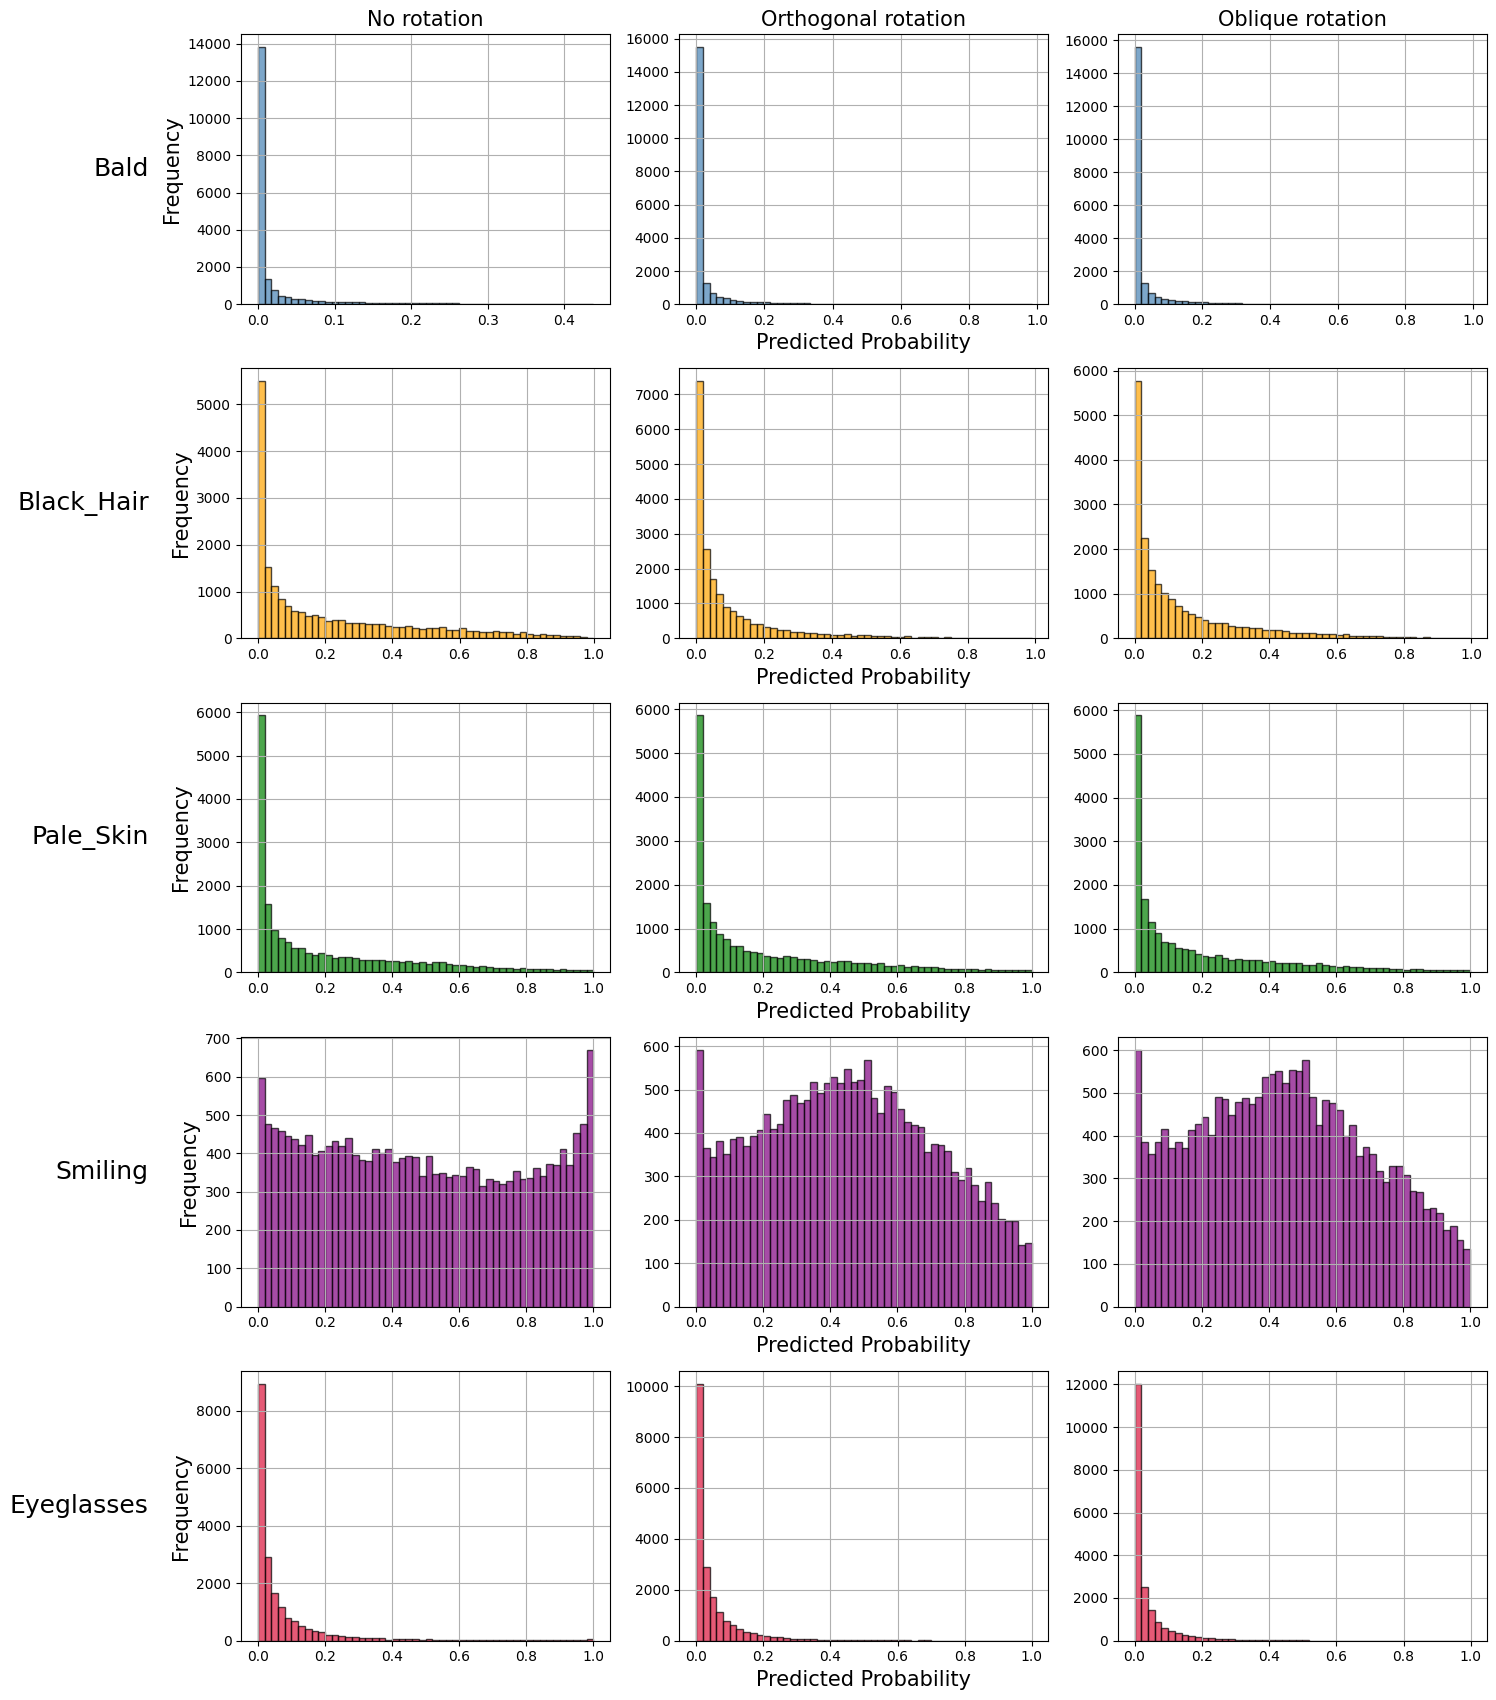

In [30]:
colour = ['steelblue', 'orange', 'green', 'purple', 'crimson']

attributes = []
for i in range(len(selected_attributes)):
    attributes.append((selected_attributes[i],baseline_predictions[i], orthogonal_predictions[i], oblique_predictions[i], colour[i]))

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 18), sharey=False)

plot_titles = ['No rotation', 'Orthogonal rotation', 'Oblique rotation']

for row_idx, (attr_name, baseline, rotated, oblique, color) in enumerate(attributes):
    data_list = [baseline, rotated, oblique]
    for col_idx, (data, title) in enumerate(zip(data_list, plot_titles)):
        ax = axes[row_idx, col_idx]
        ax.hist(data.flatten(), bins=50, color=color, alpha=0.7, edgecolor='black')
        if col_idx == 0:
            ax.set_ylabel('Frequency', fontsize=15)
        if row_idx == 0:
            ax.set_title(title, fontsize=15)
        if col_idx == 1:
            ax.set_xlabel('Predicted Probability', fontsize=15)
        ax.grid(True)
        if col_idx == 0:
            ax.text(-0.25, 0.5, attr_name, va='center', ha='right', rotation=0,
        transform=ax.transAxes, fontsize=18)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Attribute_classification_beta_VAE.jpg')
plt.show()

#  Mitigating age bias in baldness prediction and fairness analysis using latent space manipulation

# Selecting first attribute as Bald for baldness and second attribute as Young for age

In [4]:
train_first_attribute, val_first_attribute = ((df[(df['partition'] == 0)]['Bald'] + 1)/2).astype(int), ((df[(df['partition'] == 2)]['Bald'] + 1)/2).astype(int)
train_second_attribute, val_second_attribute = ((df[(df['partition'] == 0)]['Young'] + 1)/2).astype(int), ((df[(df['partition'] == 2)]['Young'] + 1)/2).astype(int)

# Applying factor rotation to the latent space representation to align Bald and Young in the first and second latent dimension respectively

In [ ]:
Z_train, Z_val, y_train, y_val, y_train_2, y_val_2 = latent_train, latent_val, train_first_attribute[:162752], val_first_attribute[:19936], train_second_attribute[:162752], val_second_attribute[:19936]

logistic_model = LogisticRegression()
logistic_model.fit(Z_train, y_train)

beta_1 = logistic_model.coef_.flatten()  # Coefficients from the logistic model for first attribute
beta_1 = beta_1 / np.linalg.norm(beta_1)

logistic_model_2 = LogisticRegression()
logistic_model_2.fit(Z_train, y_train_2)

beta_2 = logistic_model_2.coef_.flatten()  # Coefficients from the logistic model for second attribute
beta_2 = beta_2 / np.linalg.norm(beta_2)

I_n = np.eye(Z_train.shape[1])  # Identity matrix of size n x n; n = latent dimension
B = np.column_stack((beta_1, beta_2, I_n[:, 2:]))
Q, _ = np.linalg.qr(B)
R = Q

# Oblique rotation of the latent space based on chosen attributes
R_prime = np.column_stack((beta_1, beta_2, Q[:, 2:]))

# Apply the rotation
Z_train_orth_rotated = Z_train @ R
Z_val_orth_rotated = Z_val @ R

Z_train_obl_rotated = Z_train @ R_prime
Z_val_obl_rotated = Z_val @ R_prime

# Plotting the first two dimensions of the rotated latent space

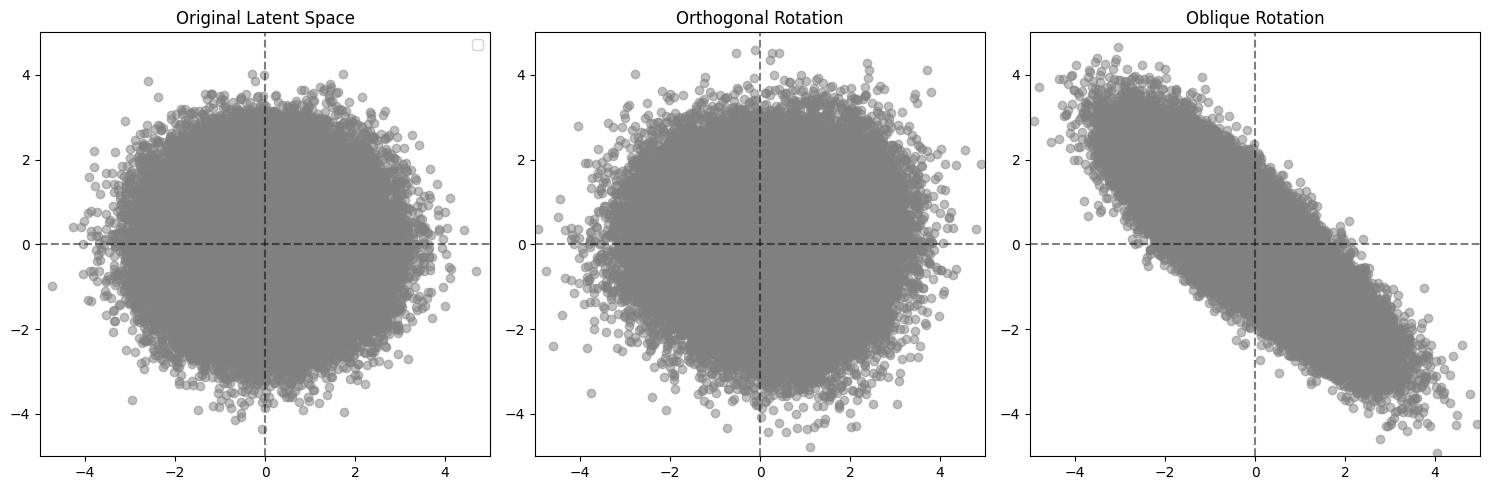

In [25]:
# ---- Visualization ----
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Latent Space
axs[0].scatter(Z_train[:, 0], Z_train[:, 1], alpha=0.5, c='gray')
axs[0].set_title("Original Latent Space")
axs[0].axvline(0, color='k', linestyle='--', alpha=0.5)
axs[0].axhline(0, color='k', linestyle='--', alpha=0.5)
axs[0].legend()
axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-5, 5)

# Orthogonal Rotation
axs[1].scatter(Z_train_orth_rotated[:, 0], Z_train_orth_rotated[:, 1], alpha=0.5, c='gray')
axs[1].axvline(0, color='k', linestyle='--', alpha=0.5)
axs[1].axhline(0, color='k', linestyle='--', alpha=0.5)
axs[1].set_title("Orthogonal Rotation")
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)

# Oblique Rotation
axs[2].scatter(Z_train_obl_rotated[:, 0], Z_train_obl_rotated[:, 1], alpha=0.5, c='gray')
axs[2].axvline(0, color='k', linestyle='--', alpha=0.5)
axs[2].axhline(0, color='k', linestyle='--', alpha=0.5)
axs[2].set_title("Oblique Rotation")
axs[2].set_xlim(-5, 5)
axs[2].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

# Manipulating the second dimension of the orthogonally rotated latent space and generating reconstructed images - Classifier 2

In [ ]:
# For Classifier 2
# After executing this block use the block defined below for generating tensorflow datasets

# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
W_adjusted = np.dot(R.T, W)
decoder.layers[1].set_weights([W_adjusted, bias])

batch_size = 32
reconstructed_images_mod_train = []

Z_train_modified = np.copy(Z_train_orth_rotated)

# Manipulation of the second dimension
Z_train_modified[np.where((y_train == 1) & (y_train_2 == 1))[0],1] += np.median(Z_train_orth_rotated[np.where((y_train == 1) & (y_train_2 == 0))[0]][:,1])
Z_train_modified[np.where((y_train == 0) & (y_train_2 == 0))[0],1] += np.median(Z_train_orth_rotated[np.where((y_train == 0) & (y_train_2 == 1))[0]][:,1])

for i in range(0, Z_train_modified.shape[0], batch_size):
    batch = np.copy(Z_train_modified[i:i + batch_size])
    reconstructed_batch = decoder.predict(batch)
    reconstructed_images_mod_train.append(reconstructed_batch)

    clear_output(wait=True)

# Combine all batches into one array
reconstructed_images_mod_train = np.concatenate(reconstructed_images_mod_train, axis=0)

Z_val_modified = np.copy(Z_val_orth_rotated)

# Manipulation of the second dimension
Z_val_modified[np.where((y_val == 1) & (y_val_2 == 1))[0],1] += np.median(Z_val_orth_rotated[np.where((y_val == 1) & (y_val_2 == 0))[0]][:,1])
Z_val_modified[np.where((y_val == 0) & (y_val_2 == 0))[0],1] += np.median(Z_val_orth_rotated[np.where((y_val == 0) & (y_val_2 == 1))[0]][:,1])

reconstructed_images_mod_val = decoder.predict(Z_val_modified)

np.save('reconstructed_images_mod_train.npy', reconstructed_images_mod_train)
np.save('reconstructed_images_mod_val.npy', reconstructed_images_mod_val)

import gc

del reconstructed_images_mod_train, reconstructed_images_mod_val
gc.collect()

# Manipulating the second dimension of the orthogonally rotated latent space and generating reconstructed images - Classifier 3

In [ ]:
# Classifier 3
# After executing this block use the block below to generate tensorflow datasets

# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
W_adjusted = np.dot(R.T, W)
decoder.layers[1].set_weights([W_adjusted, bias])

batch_size = 32
reconstructed_images_mod_train = []

Z_train_modified = np.copy(Z_train_orth_rotated)
corr, _ = pointbiserialr(y_train_2, Z_train_orth_rotated[:, 1])

if corr > 0:
    median = np.abs((np.median(Z_train_orth_rotated[np.where(y_train_2 == 0)[0]][:,1])+
                   np.median(Z_train_orth_rotated[np.where(y_train_2 == 1)[0]][:,1]))/2.0)
else:
    median = -1.0 * np.abs((np.median(Z_train_orth_rotated[np.where(y_train_2 == 0)[0]][:,1])+
                   np.median(Z_train_orth_rotated[np.where(y_train_2 == 1)[0]][:,1]))/2.0)
    
# Manipulation of the second dimension
Z_train_modified[:,1] += median 

for i in range(0, Z_train_modified.shape[0], batch_size):
    batch = np.copy(Z_train_modified[i:i + batch_size])
    reconstructed_batch = decoder.predict(batch)
    reconstructed_images_mod_train.append(reconstructed_batch)

    clear_output(wait=True)

# Combine all batches into one array
reconstructed_images_mod_train = np.concatenate(reconstructed_images_mod_train, axis=0)

Z_val_modified = np.copy(Z_val_orth_rotated)
corr, _ = pointbiserialr(y_val_2, Z_val_orth_rotated[:, 1])

if corr > 0:
    median = np.abs((np.median(Z_val_orth_rotated[np.where(y_val_2 == 0)[0]][:,1]) + 
                       np.median(Z_val_orth_rotated[np.where(y_val_2 == 1)[0]][:,1]))/2.0)
else:
    median = -1.0 * np.abs((np.median(Z_val_orth_rotated[np.where(y_val_2 == 0)[0]][:,1]) + 
                       np.median(Z_val_orth_rotated[np.where(y_val_2 == 1)[0]][:,1]))/2.0)

# Manipulation of the second dimension
Z_val_modified[:,1] += median

reconstructed_images_mod_val = decoder.predict(Z_val_modified)

np.save('reconstructed_images_mod_train.npy', reconstructed_images_mod_train)
np.save('reconstructed_images_mod_val.npy', reconstructed_images_mod_val)

import gc

del reconstructed_images_mod_train, reconstructed_images_mod_val
gc.collect()

# Creating tensorFlow datasets from numpy arrays using generators for efficient data loading

In [ ]:
# After executing this block use the DNN classifier training block declared earlier to train

reconstructed_images_mod_train = np.load('/kaggle/working/reconstructed_images_mod_train.npy', mmap_mode='r')
reconstructed_images_mod_val = np.load('/kaggle/working/reconstructed_images_mod_val.npy', mmap_mode='r')

batch_size = 32

# Create a generator function that yields data in batches
def data_generator_train():
    for i in range(0, len(reconstructed_images_mod_train), batch_size):
        yield reconstructed_images_mod_train[i:i+batch_size]

# Convert the generator to a tf.data.Dataset
reconstructed_images_train_dataset = tf.data.Dataset.from_generator(
    data_generator_train, 
    output_signature=tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)



def data_generator_val():
    for i in range(0, len(reconstructed_images_mod_val), batch_size):
        yield reconstructed_images_mod_val[i:i+batch_size]

reconstructed_images_val_dataset = tf.data.Dataset.from_generator(
    data_generator_val, 
    output_signature=tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)

reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train).batch(32))) 
reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val).batch(32)))

reconstructed_dataset_with_labels_train = reconstructed_dataset_with_labels_train.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
reconstructed_dataset_with_labels_val = reconstructed_dataset_with_labels_val.prefetch(tf.data.AUTOTUNE)

# Loading the test dataset for predicting Bald attribute to evaluate bias mitigation and fairness

In [17]:
test_files = partition_df[(partition_df['partition'] == 1)]['image_id'].tolist()

test_files = [os.path.join(img_dir, img_id) for img_id in test_files]

# Creating TensorFlow datasets for training and testing
test_dataset = tf.data.Dataset.from_tensor_slices(test_files).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

y_test = ((df[(df['partition'] == 1)]['Bald'][:19840] + 1)/2).astype(int)
y_test_2 = ((df[(df['partition'] == 1)]['Young'][:19840] + 1)/2).astype(int)

decoder.layers[1].set_weights([W, bias])
reconstructed_images_test = vae.predict(test_dataset)

batch_size = 32
def data_generator_test():
    for i in range(0, len(reconstructed_images_test), batch_size):
        yield reconstructed_images_test[i:i+batch_size]

reconstructed_images_test_dataset = tf.data.Dataset.from_generator(
    data_generator_test, 
    output_signature=tf.TensorSpec(shape=(None,64,64,3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)

reconstructed_dataset_with_labels_test = tf.data.Dataset.zip((reconstructed_images_test_dataset, tf.data.Dataset.from_tensor_slices(y_test).map(lambda x: tf.expand_dims(x, -1))))
reconstructed_dataset_with_labels_test = reconstructed_dataset_with_labels_test.prefetch(tf.data.AUTOTUNE)

620/620 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step


# Loading DNN classifiers for predicting Bald attribute

In [19]:
# Loading saved DNN classifier to rate baldness

score_model_no_rotation = tf.keras.models.load_model('/kaggle/input/bald-attribute-predict-model/bald_attribute_predict_model_no_rot_epoch30.h5') # Classifier 1
score_model_orth_rotation_1 = tf.keras.models.load_model('/kaggle/input/bald-attribute-predict-model/bald_attribute_predict_model_orth_rot_epoch30_VAE_clf_2.h5') # Classifier 2
score_model_orth_rotation_2 = tf.keras.models.load_model('/kaggle/input/bald-attribute-predict-model/bald_attribute_predict_model_orth_rot_epoch30_VAE_clf_3.h5') # Classifier 3

score_model_no_rotation.summary()
score_model_orth_rotation_1.summary()
score_model_orth_rotation_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,171 (668.64 KB)

 Trainable params: 171,169 (668.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,171 (668.64 KB)

 Trainable params: 171,169 (668.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,171 (668.64 KB)

 Trainable params: 171,169 (668.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# ROC AUC score for predicting Bald attribute for all groups

In [36]:
# Calculating roc auc score for all samples in the test dataset

y_test_1_proba = score_model_no_rotation.predict(reconstructed_images_test_dataset)
y_test_2_proba = score_model_orth_rotation_1.predict(reconstructed_images_test_dataset)
y_test_3_proba = score_model_orth_rotation_2.predict(reconstructed_images_test_dataset)


auc_roc_1 = roc_auc_score(y_test, y_test_1_proba)
auc_roc_2 = roc_auc_score(y_test, y_test_2_proba)
auc_roc_3 = roc_auc_score(y_test, y_test_3_proba)

auc_roc_1,auc_roc_2, auc_roc_3

620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(0.9101083500859515, 0.9168184765066992, 0.9192245168915605)

# ROC AUC score for predicting Bald attribute for young group

In [37]:
# Calculating roc auc score for young subgroup in the test dataset

y_test_1_proba_y = y_test_1_proba[np.where(y_test_2 == 1)[0]]
y_test_2_proba_y = y_test_2_proba[np.where(y_test_2 == 1)[0]]
y_test_3_proba_y = y_test_3_proba[np.where(y_test_2 == 1)[0]]
y_test_y = y_test[y_test_2 == 1]

auc_roc_1_y = roc_auc_score(y_test_y, y_test_1_proba_y)
auc_roc_2_y = roc_auc_score(y_test_y, y_test_2_proba_y)
auc_roc_3_y = roc_auc_score(y_test_y, y_test_3_proba_y)

auc_roc_1_y,auc_roc_2_y, auc_roc_3_y

(0.9092047701726896, 0.9112746853100189, 0.9250108115530267)

# ROC AUC score for predicting Bald attribute for not young group

In [38]:
# Calculating roc auc score for not young subgroup in the test dataset

y_test_1_proba_ny = y_test_1_proba[np.where(y_test_2 == 0)[0]]
y_test_2_proba_ny = y_test_2_proba[np.where(y_test_2 == 0)[0]]
y_test_3_proba_ny = y_test_3_proba[np.where(y_test_2 == 0)[0]]

y_test_ny = y_test[y_test_2 == 0]

auc_roc_1_ny = roc_auc_score(y_test_ny, y_test_1_proba_ny)
auc_roc_2_ny = roc_auc_score(y_test_ny, y_test_2_proba_ny)
auc_roc_3_ny = roc_auc_score(y_test_ny, y_test_3_proba_ny)

auc_roc_1_ny,auc_roc_2_ny,auc_roc_3_ny

(0.8587572757608763, 0.8643850204310997, 0.8603699104361641)

# ROC curve comparison 

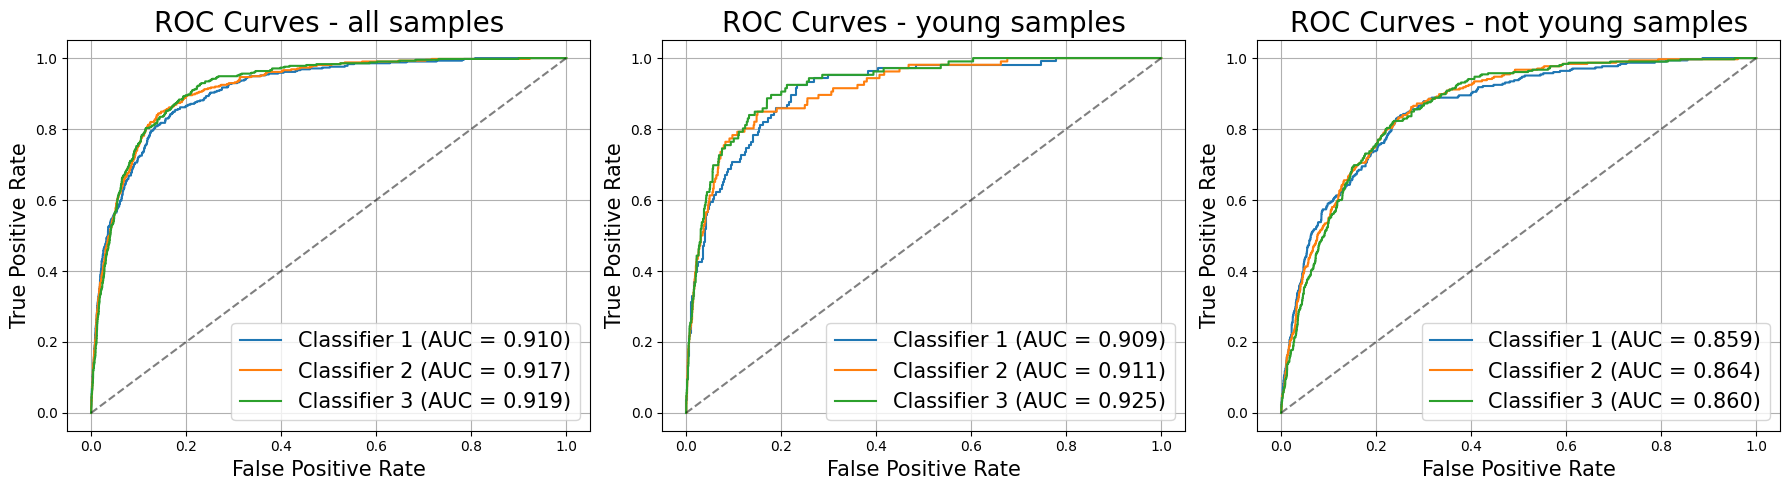

In [40]:
# Calculating false positive rate and true positive rate
fpr_1, tpr_1, _ = roc_curve(y_test, y_test_1_proba)  # Classifer 1
fpr_2, tpr_2, _ = roc_curve(y_test, y_test_2_proba)  # Classifer 2
fpr_3, tpr_3, _ = roc_curve(y_test, y_test_3_proba)  # Classifer 2

fpr_1_y, tpr_1_y, _ = roc_curve(y_test_y, y_test_1_proba_y) 
fpr_2_y, tpr_2_y, _ = roc_curve(y_test_y, y_test_2_proba_y)
fpr_3_y, tpr_3_y, _ = roc_curve(y_test_y, y_test_3_proba_y)

fpr_1_ny, tpr_1_ny, _ = roc_curve(y_test_ny, y_test_1_proba_ny) 
fpr_2_ny, tpr_2_ny, _ = roc_curve(y_test_ny, y_test_2_proba_ny)
fpr_3_ny, tpr_3_ny, _ = roc_curve(y_test_ny, y_test_3_proba_ny)

# Compute AUC scores
auc_roc_1 = auc(fpr_1, tpr_1)
auc_roc_2 = auc(fpr_2, tpr_2)
auc_roc_3 = auc(fpr_3, tpr_3)

auc_roc_1_y = auc(fpr_1_y, tpr_1_y)
auc_roc_2_y = auc(fpr_2_y, tpr_2_y)
auc_roc_3_y = auc(fpr_3_y, tpr_3_y)

auc_roc_1_ny = auc(fpr_1_ny, tpr_1_ny)
auc_roc_2_ny = auc(fpr_2_ny, tpr_2_ny)
auc_roc_3_ny = auc(fpr_3_ny, tpr_3_ny)

# Plot ROC curves
plt.figure(figsize=(18, 5))

# Plot 1: all population
plt.subplot(1, 3, 1)
plt.plot(fpr_1, tpr_1, label=f"Classifier 1 (AUC = {auc_roc_1:.3f})")
plt.plot(fpr_2, tpr_2, label=f"Classifier 2 (AUC = {auc_roc_2:.3f})")
plt.plot(fpr_3, tpr_3, label=f"Classifier 3 (AUC = {auc_roc_3:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curves - all samples", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

# Plot 2: young population
plt.subplot(1, 3, 2)
plt.plot(fpr_1_y, tpr_1_y, label=f"Classifier 1 (AUC = {auc_roc_1_y:.3f})")
plt.plot(fpr_2_y, tpr_2_y, label=f"Classifier 2 (AUC = {auc_roc_2_y:.3f})")
plt.plot(fpr_3_y, tpr_3_y, label=f"Classifier 3 (AUC = {auc_roc_3_y:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curves - young samples", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

# Plot 3: not young population
plt.subplot(1, 3, 3)
plt.plot(fpr_1_ny, tpr_1_ny, label=f"Classifier 1 (AUC = {auc_roc_1_ny:.3f})")
plt.plot(fpr_2_ny, tpr_2_ny, label=f"Classifier 2 (AUC = {auc_roc_2_ny:.3f})")
plt.plot(fpr_3_ny, tpr_3_ny, label=f"Classifier 3 (AUC = {auc_roc_3_ny:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curves - not young samples", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

plt.tight_layout()


# Plot diagonal line for reference
plt.savefig('roc_auc_score.jpg',dpi=300, bbox_inches='tight')

# Show plot
plt.show()